# classifications avec TF

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = "/content/drive/MyDrive/MASTER IA/exercices IA/"

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from numpy import asarray


# Vérifier la version de TensorFlow
print(f"TensorFlow version: {tf.__version__}")



TensorFlow version: 2.18.0


In [4]:
#exercice de pré processing pour préparer mes images (format jpg)
#test sur une image d'abord

image = Image.open(dataset_path+'cat_vs_dog_datasets/training_set/cats/cat.2.jpg')

img_matrix = asarray(image)

# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

print(img_matrix.shape)

JPEG
(312, 396)
RGB
(396, 312, 3)


In [5]:
import os
from tqdm import tqdm  # Pour afficher une barre de progression

def charger_dataset(dossier_base, taille=(128, 128)):
    categories = ['cats', 'dogs']  # Vos sous-dossiers
    X = []  # Pour stocker les images
    y = []  # Pour stocker les étiquettes (0: chat, 1: chien)

    for idx, categorie in enumerate(categories):
        chemin_categorie = os.path.join(dossier_base, categorie)
        print(f"Chargement des images de {categorie}...")

        # Liste tous les fichiers dans le dossier
        fichiers = os.listdir(chemin_categorie)

        # Parcours avec barre de progression
        for fichier in tqdm(fichiers):
            if fichier.endswith(('.jpg', '.jpeg', '.png')):
                chemin_image = os.path.join(chemin_categorie, fichier)

                try:
                    # Ouvrir l'image
                    image = Image.open(chemin_image)

                    # Redimensionner
                    image = image.resize(taille)

                    # Convertir en array numpy
                    image_array = np.array(image)

                    # Vérifier si l'image est en RGB (3 canaux)
                    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
                        # Ajouter l'image et son étiquette aux listes
                        X.append(image_array)
                        y.append(idx)  # 0 pour chat, 1 pour chien
                    else:
                        print(f"Image ignorée (pas en RGB): {chemin_image}")

                except Exception as e:
                    print(f"Erreur avec l'image {chemin_image}: {e}")

    # Convertir en arrays numpy
    X = np.array(X)
    y = np.array(y)

    # Mélanger les données
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    return X, y

# Utilisation
X_train, y_train = charger_dataset(dataset_path+'cat_vs_dog_datasets/training_set')
X_test, y_test = charger_dataset(dataset_path+'cat_vs_dog_datasets/test_set')

# Normalisation
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")

Chargement des images de cats...


100%|██████████| 4000/4000 [02:00<00:00, 33.32it/s] 


Chargement des images de dogs...


100%|██████████| 4000/4000 [01:57<00:00, 34.15it/s] 


Chargement des images de cats...


100%|██████████| 1000/1000 [00:32<00:00, 30.43it/s]


Chargement des images de dogs...


100%|██████████| 1000/1000 [00:25<00:00, 38.52it/s]


Shape de X_train: (8000, 128, 128, 3)
Shape de y_train: (8000,)


In [6]:
print(f"Shape de X_test: {X_test.shape}")

Shape de X_test: (2000, 128, 128, 3)


In [7]:
import matplotlib.pyplot as plt


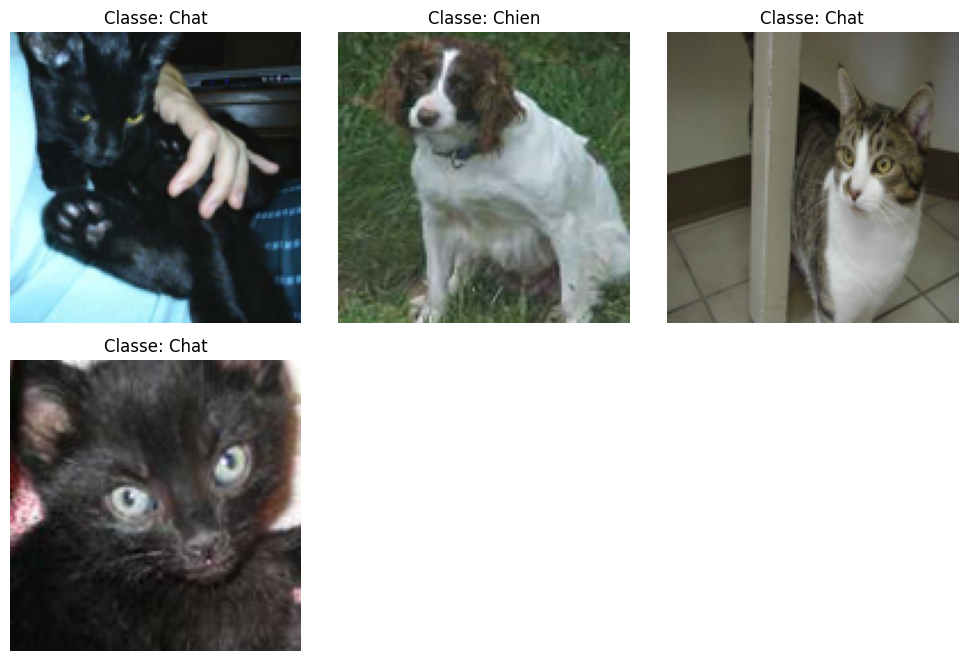

In [8]:
import matplotlib.pyplot as plt

   # Afficher quelques images
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Classe: {'Chat' if y_train[i]==0 else 'Chien'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.regularizers import l2

In [28]:

# Avant le modèle.fit()
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.01),  # Variation de contraste
    tf.keras.layers.RandomBrightness(0.01)  # Variation de luminosité

])


# Création du modèle CNN avec explications
model = Sequential([
    data_augmentation,
    # Première couche de convolution
    # 32 : nombre de filtres (détecteurs de caractéristiques)
    # (3, 3) : taille de la fenêtre de convolution
    # activation='relu' : fonction d'activation qui garde les valeurs positives
    # input_shape : forme de nos images (hauteur, largeur, canaux)
    Conv2D(16, (3, 3), activation='relu',
           padding='same',
           input_shape=(128, 128, 3),
          #  kernel_regularizer=l2(0.003)
           ),
    # Réduction de la dimension spatiale par 2
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),


    Conv2D(32, (3, 3), activation='relu',
           padding='same',
          #  kernel_regularizer=l2(0.003)
           ),
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),


    # Troisième couche de convolution : encore plus de filtres
    Conv2D(128, (3, 3), activation='relu',
           padding='same',
          #  kernel_regularizer=l2(0.003)
           ),
    MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # Aplatissement : transformation de la matrice 3D en vecteur 1D
    Flatten(),

    # C'est ici que se fait la "prise de décision"
    Dense(128, activation='relu',
          kernel_regularizer=l2(0.001)
          ),
    Dropout(0.2),

    Dense(64, activation='relu',
          kernel_regularizer=l2(0.001)
          ),
    Dropout(0.2),

    # Couche de sortie : 1 neurone avec sigmoid pour la classification binaire
    # sigmoid donne une probabilité entre 0 (chat) et 1 (chien)
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

# Configuration du modèle
model.compile(
    optimizer=optimizer,  # Algorithme d'optimisation adaptatif
    loss='binary_crossentropy',  # Fonction de perte pour classification binaire
    metrics=['accuracy',
              tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]  # Area Under Curve, utile pour les classifications binaires
)
#voir ce qui peut etre intéréssant à approfondir aux niveaux de l'optimizer et des metrics aussi

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4945 - auc: 0.4982 - loss: 1.5627 - precision: 0.4843 - recall: 0.4890 - val_accuracy: 0.4930 - val_auc: 0.5031 - val_loss: 0.9217 - val_precision: 0.4827 - val_recall: 0.1950
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5137 - auc: 0.5012 - loss: 0.9068 - precision: 0.5333 - recall: 0.2020 - val_accuracy: 0.5200 - val_auc: 0.6127 - val_loss: 0.7928 - val_precision: 0.5108 - val_recall: 0.9420
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5163 - auc: 0.5017 - loss: 0.8033 - precision: 0.5374 - recall: 0.2030 - val_accuracy: 0.5525 - val_auc: 0.5622 - val_loss: 0.7370 - val_precision: 0.5758 - val_recall: 0.3990
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5182 - auc: 0.5174 - loss: 0.7503 - precision: 0.5434 - recall: 0.2542 - val_accuracy: 0.5620 - val_auc: 0.6515 - val_loss: 0.7309 - val_precision: 0.5394 - val_recall: 0.8480
Epoch 5/40
250/250 ━━━━━━━

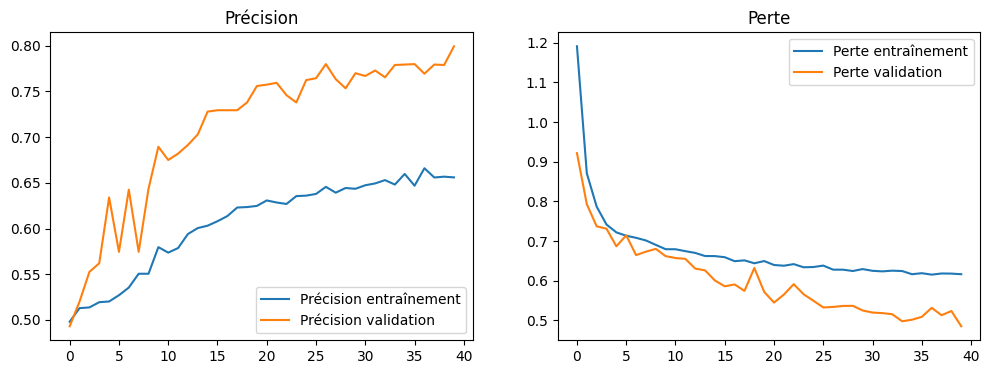

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test, y_test),
    shuffle=True,  # Mélange les données à chaque époque
    callbacks=[early_stopping],
    verbose=1
)

# Visualisation des résultats
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Précision entraînement')
plt.plot(epochs_range, val_acc, label='Précision validation')
plt.legend()
plt.title('Précision')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perte entraînement')
plt.plot(epochs_range, val_loss, label='Perte validation')
plt.legend()
plt.title('Perte')

plt.show()

#meilleur résultat sans regularize sur cnn

In [30]:
# Affichage de l'architecture du modèle
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (32, 128, 128, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 128, 128, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 64, 64, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (32, 64, 64, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (32, 64, 64, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (32, 32, 32, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (32, 32, 32, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (32, 32, 32, 128)           │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (32, 16, 16, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (32, 16, 16, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (32, 32768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (32, 128)                   │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,490,724 (32.39 MB)

 Trainable params: 4,245,185 (16.19 MB)

 Non-trainable params: 352 (1.38 KB)

 Optimizer params: 4,245,187 (16.19 MB)

In [31]:
# Évaluation sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nPrécision sur les données de test: {test_accuracy:.4f}")

# Prédictions sur quelques images de test
predictions = model.predict(X_test[:5])

# Affichage des prédictions
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i])
    pred = 'Chien' if predictions[i] > 0.5 else 'Chat'
    true = 'Chien' if y_test[i] == 1 else 'Chat'
    plt.title(f'Pred: {pred}\nVrai: {true}')
    plt.axis('off')
plt.show()

# Sauvegarde du modèle
# model.save('cat_vs_dog_model.h5')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7967 - auc: 0.8684 - loss: 0.4928 - precision: 0.8006 - recall: 0.7910


ValueError: too many values to unpack (expected 2)